## Import Packages

In [1]:
from spo.data import trivialsurgery, dataset
from spo.model import trivialSurgeryModel
from spo.func import SPOPlus
from spo.eval import unambSPO

In [2]:
import time
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader

## Build Model

In [3]:
# model for shortest path
k = 10
num_surgeries = 15
sp_model = trivialSurgeryModel(k, num_surgeries)

Academic license - for non-commercial use only - expires 2021-08-04
Using license file /Users/jmosseri/gurobi.lic


## Training

In [4]:
# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, num_surgeries)

    def forward(self, x):
        out = self.linear(x)
        return out

In [5]:
def train(dataloader, opt_model, num_epochs, learning_rate, l1_lambda=1e-3):
    """
    train model with SPO+ Loss
    args:
      dataloader: dataloader from optDataSet
      model: optModel
      num_epochs: number of epochs
      l2_lambda: l2 regularization parameter
    """
    print('Training...')
    # init model
    lr = LinearRegression()
    # cuda
    if torch.cuda.is_available():
        lr = lr.cuda()
    # training mode
    lr.train()
    # set optimizer
    optimizer = torch.optim.Adam(lr.parameters(), lr=learning_rate)
    # set SPO+ Loss as criterion
    criterion = SPOPlus()
    # train
    time.sleep(1)
    for epoch in tqdm(range(num_epochs)):
        # load data
        for i, data in enumerate(dataloader):
            x, c, w, z = data
            # cuda
            if torch.cuda.is_available():
                x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
            # forward pass
            cp = lr(x)
            loss = criterion.apply(opt_model, cp, c, w, z).mean()
            # l1 reg
            l1_reg = torch.abs(cp - c).sum(dim=1).mean()
            loss += l1_lambda * l1_reg
            # learning rate decay
            cur_lr = learning_rate * 0.6 ** math.floor((epoch / num_epochs) * 10)
            for param_group in optimizer.param_groups:
                param_group['lr'] = cur_lr
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return lr

## Experiments

### Training Set Size = 100, Noise Half−width = 0

In [6]:
# set up
n = 100 # number of data
p = 5 # size of feature
e = 0 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [7]:
# init DataFrame
df1 = pd.DataFrame(columns = degs)

In [8]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = trivialsurgery.genData(n+1000, p, num_surgeries, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-3 * (3 ** deg + 1)
        num_epochs = 500 * deg
        lr = train(sp_loader_train, sp_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, sp_model, sp_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df1 = df1.append(row, ignore_index = True)

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1420.69it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1570.08it/s]


Training...


100%|██████████| 500/500 [00:29<00:00, 16.84it/s]


Normalized SPO Loss: 2.56%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1109.15it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1705.32it/s]


Training...


100%|██████████| 1000/1000 [01:02<00:00, 15.92it/s]


Normalized SPO Loss: 0.87%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1400.21it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1763.44it/s]


Training...


100%|██████████| 2000/2000 [02:24<00:00, 13.80it/s]


Normalized SPO Loss: 0.73%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1412.45it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1766.64it/s]


Training...


100%|██████████| 3000/3000 [03:03<00:00, 16.35it/s]


Normalized SPO Loss: 1.57%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1392.41it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1814.64it/s]


Training...


100%|██████████| 500/500 [00:27<00:00, 18.18it/s]


Normalized SPO Loss: 2.55%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1422.54it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1705.91it/s]


Training...


100%|██████████| 1000/1000 [00:56<00:00, 17.64it/s]


Normalized SPO Loss: 0.38%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1442.96it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1822.80it/s]


Training...


100%|██████████| 2000/2000 [01:57<00:00, 16.96it/s]


Normalized SPO Loss: 0.30%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1473.73it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1861.81it/s]


Training...


100%|██████████| 3000/3000 [03:06<00:00, 16.04it/s]


Normalized SPO Loss: 0.91%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1374.89it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1781.64it/s]


Training...


100%|██████████| 500/500 [00:28<00:00, 17.58it/s]


Normalized SPO Loss: 3.26%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1419.24it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1814.16it/s]


Training...


100%|██████████| 1000/1000 [00:59<00:00, 16.74it/s]


Normalized SPO Loss: 0.45%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1418.47it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1750.69it/s]


Training...


100%|██████████| 2000/2000 [01:59<00:00, 16.79it/s]


Normalized SPO Loss: 0.39%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1474.45it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1803.77it/s]


Training...


100%|██████████| 3000/3000 [02:54<00:00, 17.15it/s]


Normalized SPO Loss: 1.39%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1485.25it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1876.78it/s]


Training...


100%|██████████| 500/500 [00:27<00:00, 18.12it/s]


Normalized SPO Loss: 2.06%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1459.73it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1871.23it/s]


Training...


100%|██████████| 1000/1000 [00:56<00:00, 17.54it/s]


Normalized SPO Loss: 0.18%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1473.71it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1892.88it/s]


Training...


100%|██████████| 2000/2000 [01:56<00:00, 17.15it/s]


Normalized SPO Loss: 0.21%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1509.48it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1858.94it/s]


Training...


100%|██████████| 3000/3000 [02:56<00:00, 16.99it/s]


Normalized SPO Loss: 0.72%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1247.83it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1780.94it/s]


Training...


100%|██████████| 500/500 [00:28<00:00, 17.78it/s]


Normalized SPO Loss: 3.52%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1400.73it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1755.01it/s]


Training...


100%|██████████| 1000/1000 [00:57<00:00, 17.51it/s]


Normalized SPO Loss: 2.03%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1414.95it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1472.83it/s]


Training...


100%|██████████| 2000/2000 [01:56<00:00, 17.12it/s]


Normalized SPO Loss: 0.98%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1447.82it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1801.59it/s]


Training...


100%|██████████| 3000/3000 [02:56<00:00, 17.03it/s]


Normalized SPO Loss: 2.06%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1420.13it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1816.74it/s]


Training...


100%|██████████| 500/500 [00:27<00:00, 18.06it/s]


Normalized SPO Loss: 1.97%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1441.18it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1818.59it/s]


Training...


100%|██████████| 1000/1000 [00:57<00:00, 17.26it/s]


Normalized SPO Loss: 0.37%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1401.97it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1752.19it/s]


Training...


100%|██████████| 2000/2000 [01:56<00:00, 17.11it/s]


Normalized SPO Loss: 0.40%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1400.01it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1805.76it/s]


Training...


100%|██████████| 3000/3000 [02:55<00:00, 17.09it/s]


Normalized SPO Loss: 1.49%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1437.54it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1786.55it/s]


Training...


100%|██████████| 500/500 [00:27<00:00, 18.09it/s]


Normalized SPO Loss: 2.01%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1420.76it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1828.75it/s]


Training...


100%|██████████| 1000/1000 [00:57<00:00, 17.35it/s]


Normalized SPO Loss: 0.12%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1472.71it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1773.91it/s]


Training...


100%|██████████| 2000/2000 [01:57<00:00, 16.98it/s]


Normalized SPO Loss: 0.22%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1425.49it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1793.58it/s]


Training...


100%|██████████| 3000/3000 [02:56<00:00, 17.03it/s]


Normalized SPO Loss: 0.71%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1417.88it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1818.26it/s]


Training...


100%|██████████| 500/500 [00:27<00:00, 18.05it/s]


Normalized SPO Loss: 1.90%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1428.18it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1763.89it/s]


Training...


100%|██████████| 1000/1000 [00:56<00:00, 17.58it/s]


Normalized SPO Loss: 0.10%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1497.07it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1877.21it/s]


Training...


100%|██████████| 2000/2000 [01:55<00:00, 17.31it/s]


Normalized SPO Loss: 0.17%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1475.77it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1895.02it/s]


Training...


100%|██████████| 3000/3000 [02:51<00:00, 17.47it/s]


Normalized SPO Loss: 0.61%



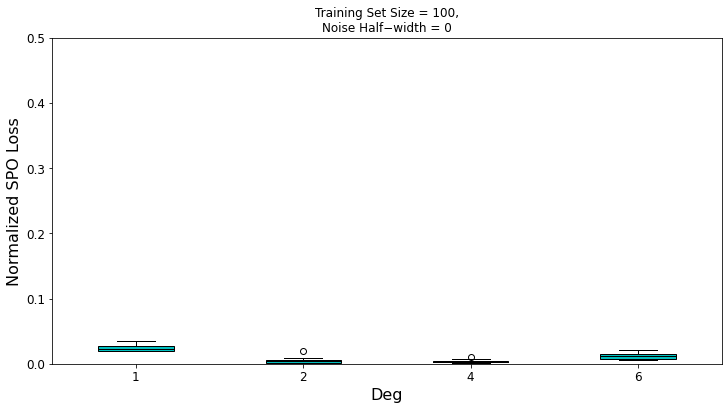

In [9]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df1, boxprops=dict(facecolor='c', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 100,\nNoise Half−width = 0')
plt.show()

### Training Set Size = 100, Noise Half−width = 0.5

In [10]:
# set
n = 100 # number of data
p = 5 # size of feature
e = 0.5 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [11]:
# init DataFrame
df2 = pd.DataFrame(columns = degs)

In [12]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = trivialsurgery.genData(n+1000, p, num_surgeries, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-3 * (3 ** deg + 1)
        num_epochs = 500 * deg
        lr = train(sp_loader_train, sp_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, sp_model, sp_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df2 = df2.append(row, ignore_index = True)

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1521.12it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1941.89it/s]


Training...


100%|██████████| 500/500 [00:26<00:00, 18.53it/s]


Normalized SPO Loss: 20.22%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1583.38it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1891.14it/s]


Training...


100%|██████████| 1000/1000 [00:55<00:00, 18.13it/s]


Normalized SPO Loss: 13.17%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1528.23it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1877.87it/s]


Training...


100%|██████████| 2000/2000 [01:52<00:00, 17.71it/s]


Normalized SPO Loss: 9.27%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1499.57it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1929.13it/s]


Training...


100%|██████████| 3000/3000 [02:50<00:00, 17.62it/s]


Normalized SPO Loss: 9.59%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1665.27it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1887.89it/s]


Training...


100%|██████████| 500/500 [00:27<00:00, 18.50it/s]


Normalized SPO Loss: 18.72%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1533.01it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1956.21it/s]


Training...


100%|██████████| 1000/1000 [00:55<00:00, 18.09it/s]


Normalized SPO Loss: 11.90%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1512.74it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1957.33it/s]


Training...


100%|██████████| 2000/2000 [01:51<00:00, 17.93it/s]


Normalized SPO Loss: 8.58%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1551.66it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1933.58it/s]


Training...


100%|██████████| 3000/3000 [02:52<00:00, 17.42it/s]


Normalized SPO Loss: 7.84%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1568.11it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1949.24it/s]


Training...


100%|██████████| 500/500 [00:26<00:00, 18.66it/s]


Normalized SPO Loss: 17.77%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1620.07it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1941.80it/s]


Training...


100%|██████████| 1000/1000 [00:54<00:00, 18.21it/s]


Normalized SPO Loss: 11.41%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1553.55it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1940.40it/s]


Training...


100%|██████████| 2000/2000 [01:52<00:00, 17.77it/s]


Normalized SPO Loss: 8.70%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1517.75it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1915.72it/s]


Training...


100%|██████████| 3000/3000 [02:49<00:00, 17.73it/s]


Normalized SPO Loss: 9.43%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1656.43it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1953.39it/s]


Training...


100%|██████████| 500/500 [00:26<00:00, 18.72it/s]


Normalized SPO Loss: 16.87%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1575.94it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1956.88it/s]


Training...


100%|██████████| 1000/1000 [00:54<00:00, 18.27it/s]


Normalized SPO Loss: 10.89%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1518.33it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1967.47it/s]


Training...


100%|██████████| 2000/2000 [01:52<00:00, 17.84it/s]


Normalized SPO Loss: 7.97%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1555.76it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1943.53it/s]


Training...


100%|██████████| 3000/3000 [02:50<00:00, 17.58it/s]


Normalized SPO Loss: 7.60%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1511.76it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1771.90it/s]


Training...


100%|██████████| 500/500 [00:27<00:00, 17.86it/s]


Normalized SPO Loss: 18.30%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1577.29it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1952.66it/s]


Training...


100%|██████████| 1000/1000 [00:55<00:00, 18.04it/s]


Normalized SPO Loss: 13.74%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1552.05it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1948.16it/s]


Training...


100%|██████████| 2000/2000 [01:53<00:00, 17.60it/s]


Normalized SPO Loss: 9.49%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1543.83it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1935.46it/s]


Training...


100%|██████████| 3000/3000 [02:48<00:00, 17.82it/s]


Normalized SPO Loss: 9.09%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1541.50it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1961.25it/s]


Training...


100%|██████████| 500/500 [00:26<00:00, 18.54it/s]


Normalized SPO Loss: 17.60%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1993.95it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1925.84it/s]


Training...


100%|██████████| 1000/1000 [00:55<00:00, 17.95it/s]


Normalized SPO Loss: 11.47%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1982.78it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1958.88it/s]


Training...


100%|██████████| 2000/2000 [01:52<00:00, 17.76it/s]


Normalized SPO Loss: 9.54%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1621.28it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1902.27it/s]


Training...


100%|██████████| 3000/3000 [02:47<00:00, 17.87it/s]


Normalized SPO Loss: 10.85%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1553.33it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1846.61it/s]


Training...


100%|██████████| 500/500 [00:26<00:00, 18.74it/s]


Normalized SPO Loss: 17.14%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1567.57it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1966.65it/s]


Training...


100%|██████████| 1000/1000 [00:55<00:00, 18.13it/s]


Normalized SPO Loss: 11.30%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1670.90it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1958.43it/s]


Training...


100%|██████████| 2000/2000 [01:52<00:00, 17.74it/s]


Normalized SPO Loss: 9.17%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1548.81it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1967.66it/s]


Training...


100%|██████████| 3000/3000 [02:49<00:00, 17.70it/s]


Normalized SPO Loss: 9.26%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1551.35it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1940.85it/s]


Training...


100%|██████████| 500/500 [00:26<00:00, 18.95it/s]


Normalized SPO Loss: 18.90%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1549.62it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1919.33it/s]


Training...


100%|██████████| 1000/1000 [00:54<00:00, 18.39it/s]


Normalized SPO Loss: 11.33%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1538.01it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1483.53it/s]


Training...


100%|██████████| 2000/2000 [01:53<00:00, 17.60it/s]


Normalized SPO Loss: 8.48%

Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 1694.54it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1939.46it/s]


Training...


100%|██████████| 3000/3000 [02:49<00:00, 17.70it/s]


Normalized SPO Loss: 7.59%



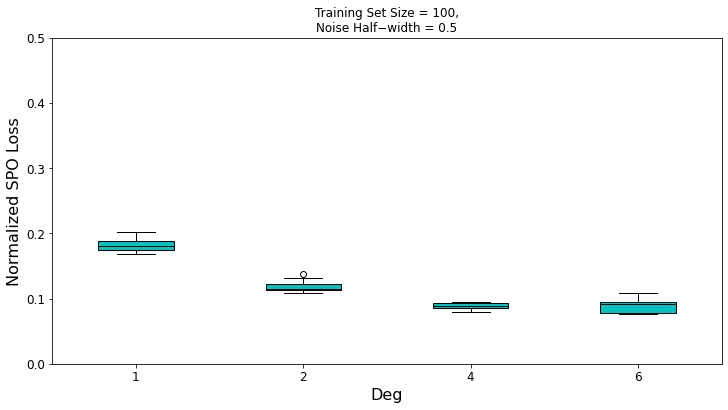

In [13]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df2, boxprops=dict(facecolor='c', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 100,\nNoise Half−width = 0.5')
plt.show()

## Training Set Size = 1000, Noise Half−width = 0

In [14]:
# set
n = 1000 # number of data
p = 5 # size of feature
e = 0 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [15]:
# init DataFrame
df3 = pd.DataFrame(columns = degs)

In [16]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = trivialsurgery.genData(n+1000, p, num_surgeries, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-3 * (3 ** deg + 1)
        num_epochs = 50 * deg
        lr = train(sp_loader_train, sp_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, sp_model, sp_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df3 = df3.append(row, ignore_index = True)

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1859.98it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1887.82it/s]


Training...


100%|██████████| 50/50 [00:25<00:00,  1.95it/s]


Normalized SPO Loss: 3.14%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1920.52it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1793.22it/s]


Training...


100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


Normalized SPO Loss: 0.09%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1810.11it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1775.37it/s]


Training...


100%|██████████| 200/200 [01:49<00:00,  1.82it/s]


Normalized SPO Loss: 0.19%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1875.63it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1810.65it/s]


Training...


100%|██████████| 300/300 [02:43<00:00,  1.84it/s]


Normalized SPO Loss: 0.27%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1897.12it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1894.46it/s]


Training...


100%|██████████| 50/50 [00:24<00:00,  2.03it/s]


Normalized SPO Loss: 3.64%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1903.72it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1842.93it/s]


Training...


100%|██████████| 100/100 [00:53<00:00,  1.87it/s]


Normalized SPO Loss: 0.07%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1869.41it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1891.91it/s]


Training...


100%|██████████| 200/200 [01:48<00:00,  1.84it/s]


Normalized SPO Loss: 0.09%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1877.51it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1880.95it/s]


Training...


100%|██████████| 300/300 [02:45<00:00,  1.81it/s]


Normalized SPO Loss: 0.22%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1900.33it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1877.33it/s]


Training...


100%|██████████| 50/50 [00:25<00:00,  1.99it/s]


Normalized SPO Loss: 4.82%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1871.96it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1913.06it/s]


Training...


100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


Normalized SPO Loss: 0.18%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1904.84it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1913.16it/s]


Training...


100%|██████████| 200/200 [01:48<00:00,  1.84it/s]


Normalized SPO Loss: 0.09%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1913.77it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1871.46it/s]


Training...


100%|██████████| 300/300 [02:44<00:00,  1.82it/s]


Normalized SPO Loss: 0.30%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1889.38it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1961.32it/s]


Training...


100%|██████████| 50/50 [00:24<00:00,  2.01it/s]


Normalized SPO Loss: 2.47%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1839.42it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1884.36it/s]


Training...


100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


Normalized SPO Loss: 0.05%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1938.76it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1943.69it/s]


Training...


100%|██████████| 200/200 [01:51<00:00,  1.80it/s]


Normalized SPO Loss: 0.06%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1937.38it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1857.29it/s]


Training...


100%|██████████| 300/300 [02:44<00:00,  1.82it/s]


Normalized SPO Loss: 0.21%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1907.11it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1881.75it/s]


Training...


100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


Normalized SPO Loss: 3.39%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1912.23it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1750.73it/s]


Training...


100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


Normalized SPO Loss: 0.10%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1866.05it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1904.28it/s]


Training...


100%|██████████| 200/200 [01:49<00:00,  1.83it/s]


Normalized SPO Loss: 0.05%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1846.32it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1844.94it/s]


Training...


100%|██████████| 300/300 [02:44<00:00,  1.82it/s]


Normalized SPO Loss: 0.12%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1816.55it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1914.00it/s]


Training...


100%|██████████| 50/50 [00:25<00:00,  1.98it/s]


Normalized SPO Loss: 4.02%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1880.95it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1871.54it/s]


Training...


100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


Normalized SPO Loss: 0.07%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1903.31it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1908.92it/s]


Training...


100%|██████████| 200/200 [01:49<00:00,  1.82it/s]


Normalized SPO Loss: 0.08%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1911.12it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1878.45it/s]


Training...


100%|██████████| 300/300 [02:46<00:00,  1.81it/s]


Normalized SPO Loss: 0.19%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1897.86it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1915.07it/s]


Training...


100%|██████████| 50/50 [00:25<00:00,  2.00it/s]


Normalized SPO Loss: 2.65%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1849.13it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1907.46it/s]


Training...


100%|██████████| 100/100 [00:52<00:00,  1.89it/s]


Normalized SPO Loss: 0.08%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1898.45it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1828.75it/s]


Training...


100%|██████████| 200/200 [01:49<00:00,  1.82it/s]


Normalized SPO Loss: 0.05%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1909.32it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1887.45it/s]


Training...


100%|██████████| 300/300 [02:44<00:00,  1.83it/s]


Normalized SPO Loss: 0.12%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1814.17it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1903.48it/s]


Training...


100%|██████████| 50/50 [00:25<00:00,  1.97it/s]


Normalized SPO Loss: 3.10%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1896.17it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1901.40it/s]


Training...


100%|██████████| 100/100 [00:53<00:00,  1.89it/s]


Normalized SPO Loss: 0.08%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1902.81it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1901.40it/s]


Training...


100%|██████████| 200/200 [01:49<00:00,  1.82it/s]


Normalized SPO Loss: 0.05%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1863.23it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1890.85it/s]


Training...


100%|██████████| 300/300 [02:45<00:00,  1.81it/s]


Normalized SPO Loss: 0.18%



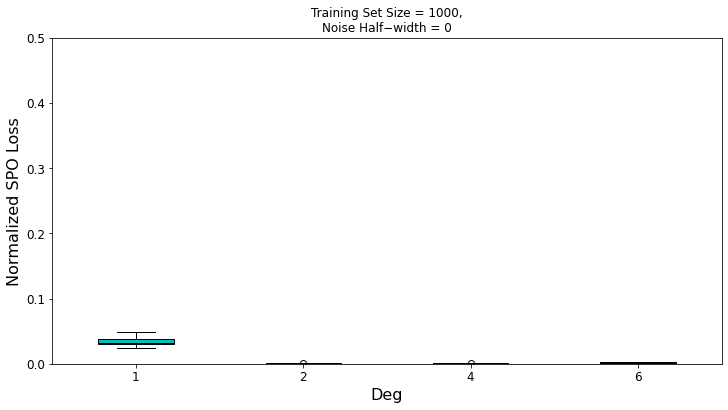

In [17]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df3, boxprops=dict(facecolor='c', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 1000,\nNoise Half−width = 0')
plt.show()

## Training Set Size = 1000, Noise Half−width = 0.5

In [18]:
# set
n = 1000 # number of data
p = 5 # size of feature
e = 0.5 # noise half−width
degs = [1, 2, 4, 6] # list of param deg

In [19]:
# init DataFrame
df4 = pd.DataFrame(columns = degs)

In [20]:
for i in range(8):
    row = {}
    for deg in degs:
        # generate data
        x, c = trivialsurgery.genData(n+1000, p, num_surgeries, deg=deg, noise_width=e, seed=i)
        # data split
        x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=i)
        # build data set
        sp_dataset_train = dataset.optDataset(sp_model, x_train, c_train)
        sp_dataset_test = dataset.optDataset(sp_model, x_test, c_test)
        # get data loader
        batch_size = 32
        sp_loader_train = DataLoader(sp_dataset_train, batch_size=batch_size, shuffle=True)
        sp_loader_test = DataLoader(sp_dataset_test, batch_size=batch_size, shuffle=False)
        # train
        learning_rate = 1e-3 * (3 ** deg + 1)
        num_epochs = 50 * deg
        lr = train(sp_loader_train, sp_model, num_epochs=num_epochs, learning_rate=learning_rate, l1_lambda=1e-3)
        # eval
        loss = unambSPO(lr, sp_model, sp_loader_test)
        print('Normalized SPO Loss: {:.2f}%'.format(loss * 100))
        row[deg] = loss
        print()
    df4 = df4.append(row, ignore_index = True)

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1945.56it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1890.01it/s]


Training...


100%|██████████| 50/50 [00:26<00:00,  1.91it/s]


Normalized SPO Loss: 17.89%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1957.78it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1948.01it/s]


Training...


100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


Normalized SPO Loss: 10.27%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1953.14it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1974.18it/s]


Training...


100%|██████████| 200/200 [01:49<00:00,  1.83it/s]


Normalized SPO Loss: 7.66%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1949.53it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1954.34it/s]


Training...


100%|██████████| 300/300 [02:43<00:00,  1.83it/s]


Normalized SPO Loss: 7.06%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1950.60it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1927.94it/s]


Training...


100%|██████████| 50/50 [00:26<00:00,  1.88it/s]


Normalized SPO Loss: 18.97%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1967.50it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1985.08it/s]


Training...


100%|██████████| 100/100 [00:53<00:00,  1.87it/s]


Normalized SPO Loss: 10.06%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1968.17it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1978.23it/s]


Training...


100%|██████████| 200/200 [01:49<00:00,  1.83it/s]


Normalized SPO Loss: 6.82%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1970.74it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1950.45it/s]


Training...


100%|██████████| 300/300 [02:43<00:00,  1.83it/s]


Normalized SPO Loss: 5.71%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1998.25it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1974.75it/s]


Training...


100%|██████████| 50/50 [00:25<00:00,  1.95it/s]


Normalized SPO Loss: 19.03%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1982.60it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1967.24it/s]


Training...


100%|██████████| 100/100 [00:54<00:00,  1.85it/s]


Normalized SPO Loss: 10.59%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1946.96it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1970.45it/s]


Training...


100%|██████████| 200/200 [01:48<00:00,  1.84it/s]


Normalized SPO Loss: 7.65%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1982.68it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1903.12it/s]


Training...


100%|██████████| 300/300 [02:43<00:00,  1.83it/s]


Normalized SPO Loss: 6.43%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1971.42it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1897.36it/s]


Training...


100%|██████████| 50/50 [00:26<00:00,  1.87it/s]


Normalized SPO Loss: 19.21%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1968.00it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1964.14it/s]


Training...


100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


Normalized SPO Loss: 9.93%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1929.92it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1978.75it/s]


Training...


100%|██████████| 200/200 [01:48<00:00,  1.84it/s]


Normalized SPO Loss: 6.52%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1900.49it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1927.78it/s]


Training...


100%|██████████| 300/300 [02:44<00:00,  1.82it/s]


Normalized SPO Loss: 5.69%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1965.15it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1646.53it/s]


Training...


100%|██████████| 50/50 [00:30<00:00,  1.62it/s]


Normalized SPO Loss: 18.43%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1841.72it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1758.17it/s]


Training...


100%|██████████| 100/100 [01:00<00:00,  1.66it/s]


Normalized SPO Loss: 10.19%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1261.25it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1822.98it/s]


Training...


100%|██████████| 200/200 [02:09<00:00,  1.54it/s]


Normalized SPO Loss: 7.13%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1793.79it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1839.80it/s]


Training...


100%|██████████| 300/300 [03:16<00:00,  1.53it/s]


Normalized SPO Loss: 5.88%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1540.62it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1415.61it/s]


Training...


100%|██████████| 50/50 [00:29<00:00,  1.67it/s]


Normalized SPO Loss: 19.30%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1417.52it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1756.22it/s]


Training...


100%|██████████| 100/100 [01:00<00:00,  1.65it/s]


Normalized SPO Loss: 10.22%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1385.14it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1725.11it/s]


Training...


100%|██████████| 200/200 [02:03<00:00,  1.62it/s]


Normalized SPO Loss: 7.14%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1896.73it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1836.63it/s]


Training...


100%|██████████| 300/300 [03:24<00:00,  1.47it/s]


Normalized SPO Loss: 6.47%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1388.31it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:01<00:00, 879.36it/s]


Training...


100%|██████████| 50/50 [00:32<00:00,  1.52it/s]


Normalized SPO Loss: 18.96%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1669.00it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1779.23it/s]


Training...


100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


Normalized SPO Loss: 10.52%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1800.19it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1500.43it/s]


Training...


100%|██████████| 200/200 [02:15<00:00,  1.48it/s]


Normalized SPO Loss: 7.52%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1747.09it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1851.56it/s]


Training...


100%|██████████| 300/300 [03:11<00:00,  1.56it/s]


Normalized SPO Loss: 7.33%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1714.38it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1737.71it/s]


Training...


100%|██████████| 50/50 [00:31<00:00,  1.59it/s]


Normalized SPO Loss: 18.63%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1793.60it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1816.24it/s]


Training...


100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Normalized SPO Loss: 10.39%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1804.03it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1529.96it/s]


Training...


100%|██████████| 200/200 [02:09<00:00,  1.54it/s]


Normalized SPO Loss: 7.21%

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1123.94it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 1791.37it/s]


Training...


100%|██████████| 300/300 [03:19<00:00,  1.50it/s]


Normalized SPO Loss: 6.02%



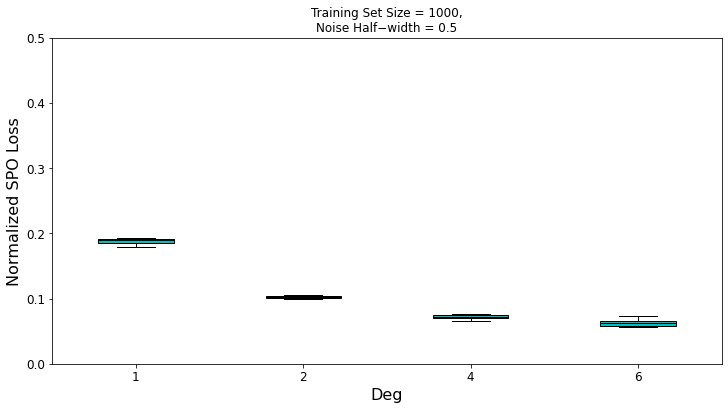

In [21]:
# draw boxplot
plt.figure(figsize=(12,6))
plt.boxplot(df4, boxprops=dict(facecolor='c', color='k'), medianprops=dict(color='k'), patch_artist=True)
plt.xlabel('Deg', fontsize=16)
plt.xticks(ticks=[1,2,3,4], labels=[1,2,4,6], fontsize=12)
plt.ylabel('Normalized SPO Loss', fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.title('Training Set Size = 1000,\nNoise Half−width = 0.5')
plt.show()

## Save File

In [22]:
df1.to_csv('./res/ts_spoplus_n100.csv', index=False)
df2.to_csv('./res/ts_spoplus_n100_noise.csv', index=False)
df3.to_csv('./res/ts_spoplus_n1000.csv', index=False)
df4.to_csv('./res/ts_spoplus_n1000_noise.csv', index=False)